In [1]:
import PyNEC
import n3ox_utils.pynec_helpers as pnh
import n3ox_utils.plot_tools as ptl 
import n3ox_utils.nfanim as nfa
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt = ptl.init_pyplot_defaults(plt)

In [3]:
figs = {}

# Wireless Inductive Coupling

This notebook uses PyNEC to simulate the resonant inductive coupling between a pair of octagonal loops and visualizes the power flowing from the source loop to the load loop using the Poynting vector:

$$\vec{P} = \vec{E}\times\vec{H}$$

I'm using PyNEC, along with some utilities that I've written to make it easier for me to use PyNEC: `n3ox_utils.pynec_helpers`, imported in this notebook as the variable `pnh`

# What is `n3ox_utils.pynec_helpers`?

I think there's some movement toward improving this, but even the object-oriented API of PyNEC has a lot of mystery calls that require you to refer to external documentation if you don't remember the order of a dozen numerical arguments.

See, for example, the Python help for the method to add an excitation to the NEC simulation: 

In [4]:
help(PyNEC.nec_context.ex_card)

Help on function ex_card in module PyNEC:

ex_card(self, *args)



Adding a ground plane at least lets you know what the number of arguments is, but I'll ever remember where to put the permittivity and conductivity without consulting the manual.

In [5]:
help(PyNEC.nec_context.gn_card)

Help on function gn_card in module PyNEC:

gn_card(self, ground_type, rad_wire_count, tmp1, tmp2, tmp3, tmp4, tmp5, tmp6)



These are really obscure for commonly (or always) used functions, and I want to improve that in my own work. I'll try to decently document what goes into my helper functions, and they use named keyword arguments and encapsulate the NEC-2 decision logic that assigns different meanings of later arguments depending on the values of earlier arguments.

In [6]:
help(pnh.pack_ex_card_args)

Help on function pack_ex_card_args in module n3ox_utils.pynec_helpers:

pack_ex_card_args(**kwargs)
    Takes named excitation parameters as keyword args and returns
    an ordered list of arguments for the .ex_card() method of 
    a PyNEC NEC context.
    
    See http://tmolteno.github.io/necpp/classnec__context.html#ae3bc2cfa92d14dfa02028ca88fbfad19
    and https://www.nec2.org/part_3/cards/ex.html
    
    Common arguments to all excitation types:
    
    excitation_type:
      voltage
      linear_wave
      r_circ_wave
      l_circ_wave
      current
      voltage_disc (current-slope-discontinuity voltage source)
    
    Arguments for voltage or voltage_disc (category A):
    
    source_tag: 
      integer tag for the excited wire
    source_seg: 
      integer tag for the excited segment on the wire
    ereal:
      real part of the voltage
    eimag:
      imaginary part of the voltage
    
    Wave and current excitations (category B & C) not yet implemented.



In [7]:
pnh.pack_ex_card_args(source_tag=15, source_seg=2,
                      excitation_type='voltage', 
                      ereal=70.7, eimag=0)

[0, 15, 2, 0, 70.7, 0, 0, 0, 0, 0]

For now I've decided against fully wrapping around PyNEC's object-oriented API with my own preferred one in `pynec_helpers`. Though it would make sense for my helper methods to be part of a class that manipulates a context stored as one of its attributes, I'd have to implement everything that PyNEC does unless I want to kind of hide or obscure that functionality from people who are using `pynec_helpers`. 

I think it'd be better to start contributing to PyNEC itself.

So instead, I will write helper functions that construct arguments for PyNEC's native function calls, and all of the PyNEC calls will be clearly visible in notebook code. Instead of mystery lists of twelve numerical arguments, there will be calls to helpers to prepare the argument list (which can be inspected easily, as above) and then those argument lists will be unpacked into PyNEC functions.

If I want to use something weird, I can just look it up and puzzle through the argument list manually.

But my helper functions mean that for common things like adding wires, excitation sources, etc., I have a much easier (and Python `help()`-ready) interface for my own use.

# Wireless Coupling -  Loop Geometry

Back to what we're actually doing. We start by generating wire dictionaries for each of the wires in two octagonal loops with "radius" `rsc.Rl` and separation `rsc.sep`.

### A Note on Namespaces
I use Python's `SimpleNamespace` type in this notebook to provide a container (`rsc` for resonantly coupled somethin' or other) for consistently-named variables across multiple NEC simulations in one notebook.

A simple namespace is really just an object with attributes, and you can store and access them with `.` notation. It's not really necessary here, because I'm not planning on having another simulation with a different NEC context in this notebook, but it could be helpful if you're writing a notebook to compare two different antennas, say `moxon = SimpleNamespace()` and `yagi = SimpleNamepace()`. So I just want to get into the habit.

# Generating Wires

I'm going about this in a slightly roundabout way because I'm building up wire dictionaries with code in this notebook that could be passed into a PyNEC command directly. However, here I want to use the `pynec_helpers.WireInput()` widget UI (**Table 1**) to 
display their 3D coordinates and other properties. So I generate the wire dictionaries, feed them into the `WireInput` widget, and then return all the wire dictionaries from there. There IS actually a useful purpose, since the `WireInput` completes otherwise incomplete wire argument dictionaries with defaults.

The first wire dictionary is a horizontal wire straddling the z-axis, and rotated and translated copies are made from that dictionary. The dictionary `rsc.wd_params` below contains common parameters for each wire, assigning each one to have 3 segments and a 10mm radius. 

In [8]:
from types import SimpleNamespace
rsc = SimpleNamespace()
rsc.Rl = 0.5 #loop "radius" in meters
rsc.thi = np.pi/180.0*22.5 #initial endpoints in meters
rsc.base_wd = {'xw1':0., 'yw1':rsc.Rl*np.sin(rsc.thi), 'zw1':rsc.Rl*np.cos(rsc.thi), 
               'xw2':0, 'yw2':rsc.Rl*np.sin(-rsc.thi), 'zw2':rsc.Rl*np.cos(-rsc.thi) }

In [9]:
# we define common params for each generated wire
rsc.wd_params = {'segment_count':3, 'rad':0.010}


Below, we set up the `WireInput` widget, clear all wires out (it starts with one), and copy and rotate wire dictionaries to set up the geometry. I'm using the methods to translate and rotate wire dictionaries to show them off. Of course, there are other ways to do this.

After I've appropriately transformed the geometry of the wire dictionary `new_wire`, I add a row to the widget and put the dict data into the row.

The widget will fill in default values for the missing tapered-wire parameter keys there.

In [10]:
wire_input = pnh.WireInput()
wire_input.delete_all_wires()
rsc.angs = np.linspace(0, 360, 8, endpoint=False) # eight 45-deg spaced rotation angles 
rsc.sep = 4.0*rsc.Rl
# set up sixteen wires, tags 1 to 16, consisting of two octagons separated by sep meters
for tagnum, ang in zip(range(1,17), np.hstack([rsc.angs, rsc.angs])):
    new_wire = rsc.base_wd.copy()
    new_wire.update(rsc.wd_params)
    new_wire['tag_id'] = tagnum
    pnh.rotate_wiredict(new_wire, ang, 'x', inplace=True)
    if tagnum<9:
        pnh.translate_wiredict(new_wire, rsc.sep/2, 'x', inplace=True)
    else:
        pnh.translate_wiredict(new_wire, -rsc.sep/2, 'x', inplace=True)
    row = wire_input.add_wire_row()
    wire_input.populate_row(row=row, wiredict=new_wire)
wire_input.show()

_**Table 1:** Wire input widget displaying the generated wire coordinates._

## Wire Geometry Visualization

**Figure 1** below visualizes the power transfer loops' geometry. 

You can modify wires in the widget above, and then re-run the cell below to see the changes, but keep in mind that this doesn't keep their ends connected like EZNEC or anything. It's not that nice yet ¯\\\_(ツ)\_/¯.

Also, re-run the widget to re-prepare the two octagons if you delete wires from the widget!


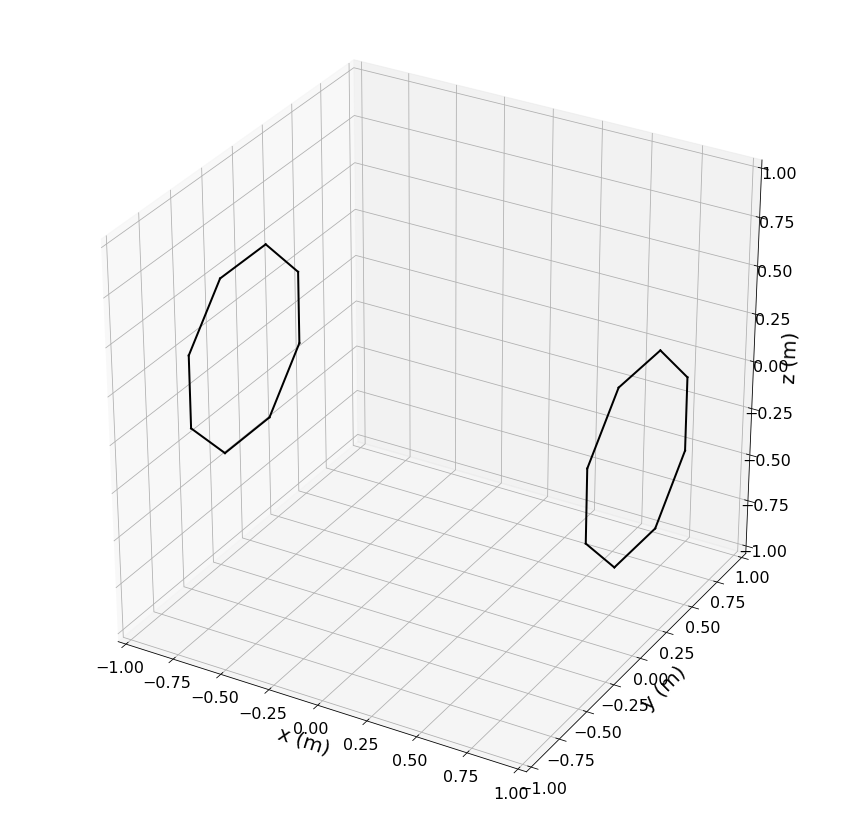

In [11]:
from mpl_toolkits.mplot3d import Axes3D # enables '3d' projection
figs[1] = plt.figure(figsize=(15,15))
figs[1].axa = figs[1].add_subplot(111, projection='3d')

for wd in wire_input.return_wire_dicts():
    p1, p2 = pnh.get_wire_points(wd)
    figs[1].axa.plot([p1[0], p2[0]], 
                     [p1[1], p2[1]], 
                     [p1[2], p2[2]], 
                     color='k')
lims = [-1, 1]
for setlim in [figs[1].axa.set_xlim, 
               figs[1].axa.set_ylim, 
               figs[1].axa.set_zlim]:
    setlim(lims)

for lab, setlab in zip(['x (m)', 'y (m)', 'z (m)'],
                       [figs[1].axa.set_xlabel, 
                        figs[1].axa.set_ylabel, 
                        figs[1].axa.set_zlabel]):
    setlab(lab, fontsize=20)



_**Figure 1:** 3D geometry of the two coupled loops._

## Adding Wires to PyNEC Geometry

The block of code below sets up a NEC "context," analagous to a NEC deck, using PyNEC. Each simulation will have a context that stores geometry, source parameters, ground plane conditions, radiation pattern setups, and all the things you might be familiar with if you use another NEC-2 simulation tool.

### PyNEC Context Manipulations

`rsc.context` is the `PyNEC` context that contains most methods (functions) for interacting with the NEC simulation.
An odd exception is that you don't add wires directly to the context, you add them to the context's geometry, which already exists when the context is created.

So, I use the context's `get_geometry()` method to get the context and bind it to the variable `rsc.geo` for convenient access.

In [12]:
rsc.context = PyNEC.nec_context()
rsc.geo = rsc.context.get_geometry()

for wd in wire_input.return_wire_dicts():
    rsc.geo.wire(**wd)
    
rsc.context.geometry_complete(0)

# Excitation

We'll use a voltage source for this simulation. Let's start with 48V in the center (seg 2) of wire 1:

In [13]:
exargs = pnh.pack_ex_card_args(source_tag=1, source_seg=2,
                               excitation_type='voltage', 
                               ereal=48.0, eimag=0)
print(f'Args for ex_card are {exargs}')
rsc.context.ex_card(*exargs)

Args for ex_card are [0, 1, 2, 0, 48.0, 0, 0, 0, 0, 0]


# Frequency

I am going to prioritize writing helpers for incomprehensible PyNEC functions.

`.fr_card()` is not one of those:

In [14]:
help(rsc.context.fr_card)

Help on method fr_card in module PyNEC:

fr_card(ifrq, nfrq, freq_hz, del_freq) method of PyNEC.nec_context instance



With the exception of remembering what `ifrq` does (0 for linear additive frequency steps, 1 for logarithmic multipliciative frequeny steps) it's pretty self-explanatory. Let's evaluate at a single frequency in the 13.56MHz ISM band. This isn't actually my field, so I don't know if it's okay to do wireless charging in this band.

In [15]:
f_ISM = 13.56
frargs = [0, 1, f_ISM, 0]
rsc.context.fr_card(*frargs)

# Loads

In [16]:
wirecond_args = pnh.pack_ld_card_args(load_type='wire_conductivity', 
                                      load_tag=0, 
                                      load_seg_start=0,
                                      wire_sigma=6.0e7) # copper for all segs


In [17]:
rsc.context.ld_card(*wirecond_args)

In [18]:
txcload_args = pnh.pack_ld_card_args(load_type='series_RLC_lump', 
                                     load_tag=5,
                                     load_seg_start=2,
                                     C=5.427e-11)
rxcload_args = pnh.pack_ld_card_args(load_type='series_RLC_lump', 
                                     load_tag=13,
                                     load_seg_start=2,
                                     C=5.427e-11)
rxload_args = pnh.pack_ld_card_args(load_type='series_RLC_lump',
                                    load_tag=9,
                                    load_seg_start=2,
                                    R=0.95)


In [19]:
rsc.context.ld_card(*txcload_args)
rsc.context.ld_card(*rxcload_args)
rsc.context.ld_card(*rxload_args)

# Radiation Pattern

I still need to do the `rp_card` but I want to prototype this thing.
It's fairly descriptive keywords, but modes and other logic are a little opaque, so I need to get around to it.

For this problem, we'll compute a far-field elevation pattern. The loops are spaced out along the x axis so we want to visualize in the XZ plane, so we want:
 * $N_{\theta}$ = 180 
 * $0<\theta<\pi$ 
 * $\theta_0$ = 0 
 * $N_{\phi}$ = 1
 * $\phi_0$ = 0

In [20]:
help(rsc.context.rp_card)

Help on method rp_card in module PyNEC:

rp_card(calc_mode, n_theta, n_phi, output_format, normalization, D, A, theta0, phi0, delta_theta, delta_phi, radial_distance, gain_norm) method of PyNEC.nec_context instance



In [21]:
elpargs = {'calc_mode':0, 'normalization':5, 
          'n_theta':361, 'theta0':0, 'delta_theta':1,
          'n_phi':1, 'phi0':0, 'delta_phi':0, 
          'radial_distance':0, 'gain_norm':0,
          'output_format':0, 'D':0, 'A':0}
rsc.context.rp_card(**elpargs)

# Near Field Pattern

In [22]:
nearfield_args = pnh.pack_nearfield_card_args(coord_system='rectangular', 
                                              nx=400, ny=1, nz=200, 
                                              x0=-4, y0=0, z0=-2, 
                                              delx=0.02, dely=0.0, delz=0.02)
rsc.context.ne_card(*nearfield_args)
rsc.context.nh_card(*nearfield_args)

In [23]:
rsc.elpattern = rsc.context.get_radiation_pattern(0)
rsc.elpgain = 10.0**(rsc.elpattern.get_gain()/10.0)

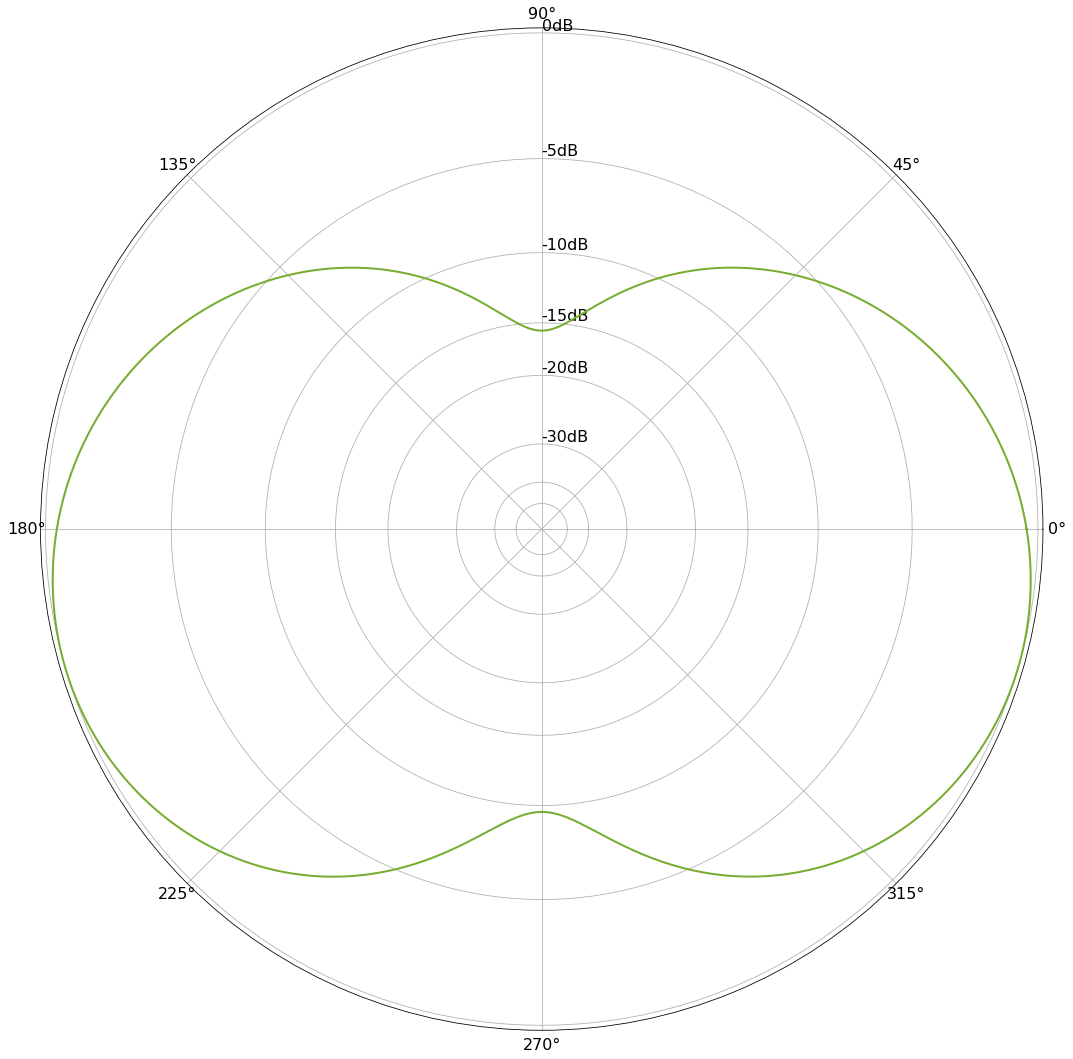

In [24]:
figs[2] = ptl.init_ARRL_polar_fig(plt)
ptl.add_ARRL_polar_plot(rsc.elpattern.get_theta_angles()*np.pi/180,
                        rsc.elpgain, 
                        ax=figs[2].axa, color=ptl.plot_colors[5])

figs[2].tight_layout()

_**Figure 2:** Elevation radiation pattern of coupled loops._

In [25]:
Z = rsc.context.get_input_parameters(0).get_impedance()
msg = 'The source loop input impedance is {0:.3f}+j{1:.3f} ohms'.format(float(Z.real), float(Z.imag))
print(msg)

The source loop input impedance is 0.968+j-0.103 ohms


Text(0.5, 0, 'z (m)')

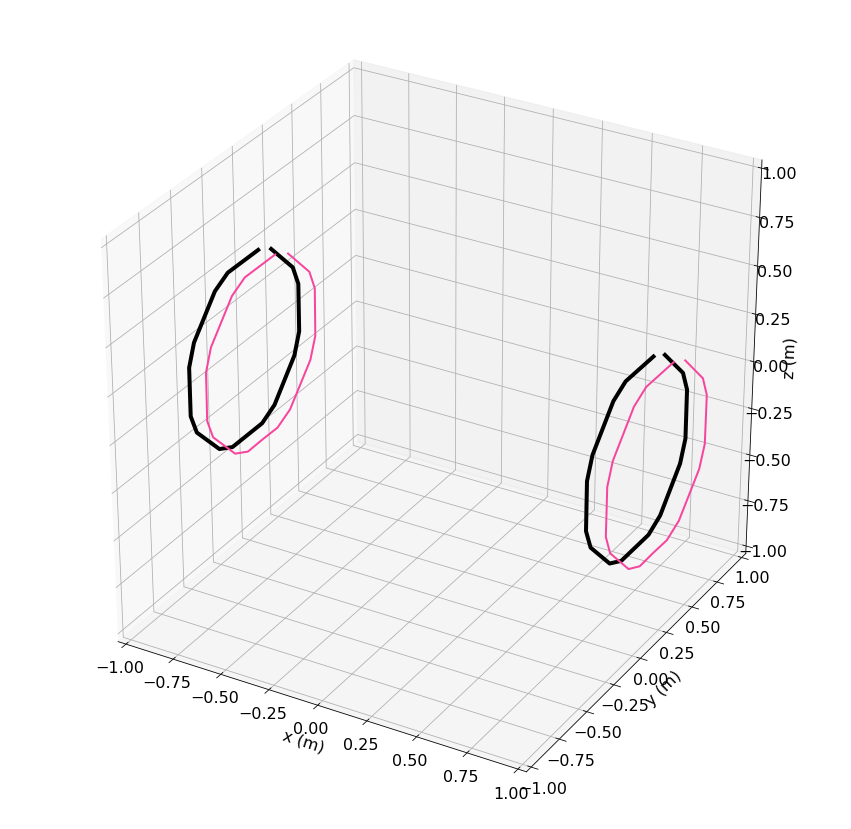

In [26]:
# --- Get structure currents --- 

rsc.currdata = rsc.context.get_structure_currents(0)
rsc.currents = rsc.currdata.get_current()

rsc.currcoords = np.asarray([
                              22.10882284*rsc.currdata.get_current_segment_center_x(),
                              22.10882284*rsc.currdata.get_current_segment_center_y(),
                              22.10882284*rsc.currdata.get_current_segment_center_z(),
                            ]).T

# --- Visualize current distribution ---
from mpl_toolkits.mplot3d import Axes3D # enables '3d' projection
figs[3] = plt.figure(figsize=(15,15))
figs[3].axa = figs[3].add_subplot(111, projection='3d')
ixsrc = 24

figs[3].axa.plot(rsc.currcoords[0:ixsrc, 0],
                 rsc.currcoords[0:ixsrc, 1],
                 rsc.currcoords[0:ixsrc, 2],
                 color='k', linewidth=4)

figs[3].axa.plot(rsc.currcoords[ixsrc:, 0],
                 rsc.currcoords[ixsrc:, 1],
                 rsc.currcoords[ixsrc:, 2],
                 color='k', linewidth=4)

currscale = 500.0
figs[3].axa.plot(rsc.currcoords[0:ixsrc, 0]+np.abs(rsc.currents[0:ixsrc])/currscale,
                 rsc.currcoords[0:ixsrc, 1],
                 rsc.currcoords[0:ixsrc, 2],
                 color='#f7459e')

figs[3].axa.plot(rsc.currcoords[ixsrc:, 0]+np.abs(rsc.currents[ixsrc:])/currscale,
                 rsc.currcoords[ixsrc:, 1],
                 rsc.currcoords[ixsrc:, 2],
                 color='#f7459e')
lims = [-1, 1]
for limsetter in [figs[3].axa.set_xlim, figs[3].axa.set_ylim, figs[3].axa.set_zlim]:
    limsetter(lims)
figs[3].axa.set_xlabel('x (m)')
figs[3].axa.set_ylabel('y (m)')
figs[3].axa.set_zlabel('z (m)')

_**Figure 3:** Current visualized on the two loops. Source loop on the right, load loop on the left._

In [27]:
rsc.nearE = rsc.context.get_near_field_pattern(0)
rsc.nearH = rsc.context.get_near_field_pattern(1)

In [28]:

rsc.E = np.array([rsc.nearE.get_field_x().reshape(200,400), 
                  rsc.nearE.get_field_y().reshape(200,400),
                  rsc.nearE.get_field_z().reshape(200,400)])
rsc.H = np.array([rsc.nearH.get_field_x().reshape(200,400), 
                  rsc.nearH.get_field_y().reshape(200,400),
                  rsc.nearH.get_field_z().reshape(200,400)])

# Poynting Vector

Given $\vec{E}$ and $\vec{H}$ we can compute the cross product.

For vectors $\vec{a} = (a_0, a_1, a_2)$ and $\vec{b} = (b_0, b_1, b_2)$, we have

$$\vec{a}\times\vec{b} = (a_1 b_2 - a_2 b_1, a_2 b_0 - a_0 b_2, a_0 b_1 - a_1 b_0 )$$

In [32]:
def poynting(cx):
    '''
    Computes the Cartesian cross product of an array
    where the first index is the component index
    '''
    cx.Px = cx.E[1,:,:]*cx.H[2,:,:]-cx.E[2,:,:]*cx.H[1,:,:]
    cx.Py = cx.E[2,:,:]*cx.H[0,:,:]-cx.E[0,:,:]*cx.H[2,:,:]
    cx.Pz = cx.E[0,:,:]*cx.H[1,:,:]-cx.E[1,:,:]*cx.H[0,:,:]
    

In [33]:
poynting(rsc)

In [34]:
rsc.phase = np.linspace(0,2*np.pi,200)

In [35]:
Pxt = rsc.Px[:, :, np.newaxis]*np.exp(-1j*rsc.phase)
Pyt = rsc.Py[:, :, np.newaxis]*np.exp(-1j*rsc.phase)
Pzt = rsc.Pz[:, :, np.newaxis]*np.exp(-1j*rsc.phase)


In [36]:
def scl(A):
    return np.sign(A)*np.abs(A)**(1/5)

NameError: name 'x' is not defined

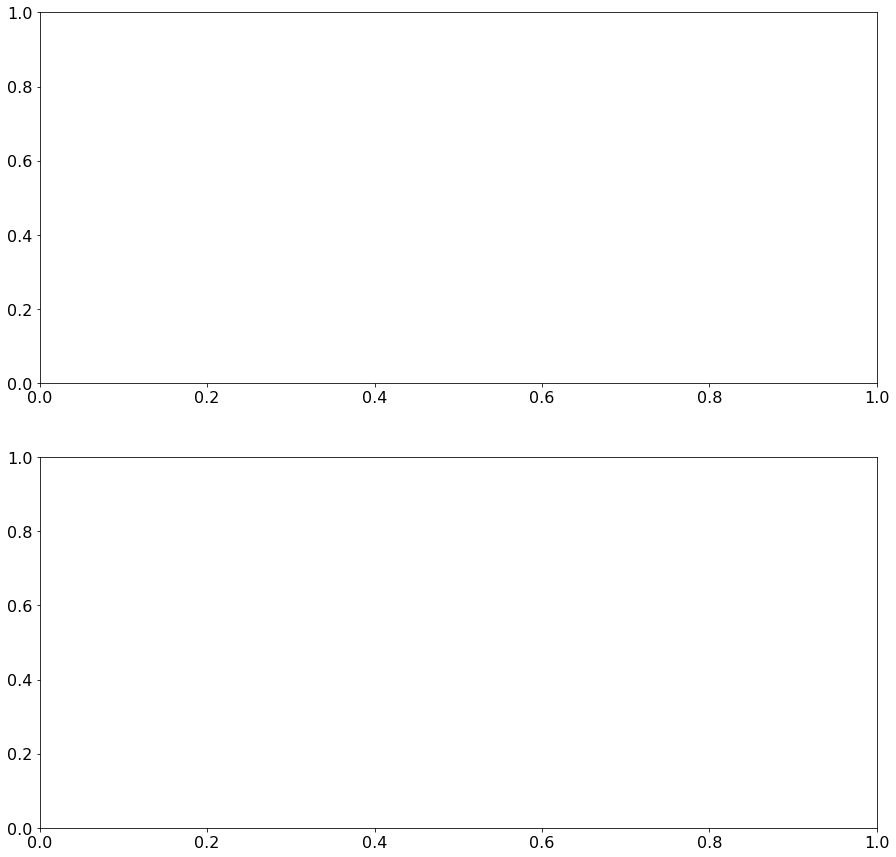

In [37]:
figs[4] = ptl.init_gridspec_fig(plt, figsize=(15,7.5*2), ncols=1, nrows=2)

figs[4].px = figs[4].axa.pcolormesh(x, z, np.squeeze(scl(Pxt[:-1,:-1, 0].real)), cmap='PuOr_r')
figs[4].pz = figs[4].axb.pcolormesh(x, z, np.squeeze(scl(Pzt[:-1,:-1,0].real)), cmap='PuOr_r', animated=True)
#figs[4].colorbar(figs[4].px)
for c in [figs[4].px, figs[4].pz]:
    c.set_clim([-15,15])

for ax, lab in zip(figs[4].axes, ['P$_x$', 'P$_z$']):
    ax.axis('off')
    ax.annotate(lab, (1.7, 0.8), fontsize=30)
    
figs[4].tight_layout(h_pad=0)
    

_**Figure 4:** Snapshots of the Poynting Vector in the vicinity of the loops._

In [39]:
rsc.__dict__

{'Rl': 0.5,
 'thi': 0.39269908169872414,
 'base_wd': {'xw1': 0.0,
  'yw1': 0.1913417161825449,
  'zw1': 0.46193976625564337,
  'xw2': 0,
  'yw2': -0.1913417161825449,
  'zw2': 0.46193976625564337},
 'wd_params': {'segment_count': 3, 'rad': 0.01},
 'angs': array([  0.,  45.,  90., 135., 180., 225., 270., 315.]),
 'sep': 2.0,
 'context': <PyNEC.nec_context; proxy of <Swig Object of type 'nec_context *' at 0x0000010C1F799840> >,
 'geo': <PyNEC.c_geometry; proxy of <Swig Object of type 'c_geometry *' at 0x0000010C1F799F30> >,
 'elpattern': <PyNEC.nec_radiation_pattern; proxy of <Swig Object of type 'nec_radiation_pattern *' at 0x0000010C1F799A50> >,
 'elpgain': array([[0.16145602],
        [0.15960546],
        [0.15767021],
        [0.15565418],
        [0.15356135],
        [0.15139578],
        [0.14916157],
        [0.14686287],
        [0.14450385],
        [0.14208872],
        [0.1396217 ],
        [0.137107  ],
        [0.13454884],
        [0.1319514 ],
        [0.12931884],
     

# Animation

Follow [this tutorial](https://alexgude.com/blog/matplotlib-blitting-supernova/)

or maybe [this](http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/)

In [121]:
for i in range(0, len(rsc.phase)):
    imfn = 'anim_images/img{0}.png'.format(str(i).zfill(5))
    Pxi = np.squeeze(scl(Pxt[:-1, :-1, i].real))
    Pzi = np.squeeze(scl(Pzt[:-1, :-1, i].real))
    figs[4].px.set_array(Pxi.flatten())
    figs[4].pz.set_array(Pzi.flatten())
    figs[4].savefig(imfn, dpi=300)
#     plt.savefig(imfn, dpi=None, facecolor='w', edgecolor='w',
#                 orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None, metadata=None)

In [116]:
#ffmpeg -r 1/5 -i img%05d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p out.mp4

<bound method Figure.savefig of <Figure size 1080x1080 with 2 Axes>>